# Quantization Aware Training

This notebook shows how to use [Brevitas](https://github.com/Xilinx/brevitas) to implement 
a small fully connected neural network that uses Quantization Aware Training (QAT). Since FHE
contraints force neural networks to be quantized to very low bit-widths (2-3 bit weights and 
activations), it is important to take quantization into account during training in order to obtain good
accuracy.

We show here how to implement and train the network with QAT and how to compile it to FHE.

In [1]:
import time

import matplotlib.pyplot as plt
import numpy
import torch
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm.auto import tqdm

from concrete.ml.quantization.quantized_module import QuantizedModule
from concrete.ml.torch.compile import compile_brevitas_qat_model

### Data-set generation

We generate a simple checkerboard pattern, which is a common benchmark for non-linear classifiers. 

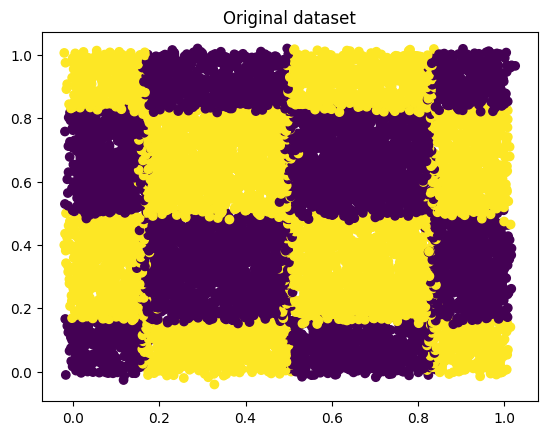

In [2]:
IN_FEAT = 2
OUT_FEAT = 2
N_SIDE = 100
N_EXAMPLE_TOTAL = N_SIDE * N_SIDE
N_TEST = 500
CLUSTERS = 3

# Generate the grid points and put them in a 2 column list of X,Y coordinates
xx, yy = numpy.meshgrid(numpy.linspace(0, 1, N_SIDE), numpy.linspace(0, 1, N_SIDE))
X = numpy.c_[numpy.ravel(xx), numpy.ravel(yy)]

# Generate the labels, using the XOR function to produce the checkerboard
y = (numpy.rint(xx * CLUSTERS).astype(numpy.int64) % 2) ^ (
    (numpy.rint(yy * CLUSTERS).astype(numpy.int64) % 2)
)
y = y.ravel()

# Add some noise to the data
X += numpy.random.randn(X.shape[0], X.shape[1]) * 0.01

# Plot the data
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.title("Original dataset")
plt.show()

# And, finally, split it into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=N_TEST / N_EXAMPLE_TOTAL, random_state=42
)

### Training loop

In this example we implement a classic simple torch training loop that can be used for both QAT and 
regular float32 networks.

In [3]:
# pylint: disable-next=too-many-arguments
def train(
    torch_model,
    X_train,
    X_test,
    y_train,
    y_test,
    criterion,
    optimizer,
    epochs=10,
    batch_size=1,
    shuffle=True,
    device="cpu",
):
    X_train = torch.tensor(X_train).float()
    X_test = torch.tensor(X_test).float()
    y_train = torch.tensor(y_train)

    train_loader = DataLoader(
        TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=shuffle
    )
    torch_model.train()
    for epoch in range(epochs):
        total_loss = []
        y_pred_all = []
        y_true_all = []

        for batch_index, (X_batch, y_batch) in enumerate(train_loader):
            # Forward pass
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            y_pred = torch_model(X_batch)
            y_pred_all.append(y_pred.argmax(1).detach().cpu().numpy())
            y_true_all.append(y_batch.detach().cpu().numpy())

            # Compute loss
            loss = criterion(y_pred, y_batch)
            if torch.isnan(loss):
                print("y_pred", y_pred)
                print("y_batch", y_batch)
                raise ValueError(f"Loss diverged at step: {batch_index}")

            # Backward pass
            optimizer.zero_grad()
            loss.backward()

            # Update weights
            optimizer.step()

            total_loss.append(loss.cpu().item())

        # Print epoch number, loss and accuracy
        y_pred_all = numpy.concatenate(y_pred_all)
        y_true_all = numpy.concatenate(y_true_all)
        accuracy = numpy.mean(y_pred_all == y_true_all)
        print(
            f"Epoch: {epoch:02} | Loss: {numpy.mean(total_loss):.4f} |"
            f" Train Accuracy: {100*accuracy:.2f}%"
        )

    # Compute test accuracy once training is done
    torch_model.eval()
    fp32_pred = torch_model(X_test.to(device)).cpu().argmax(1).float().detach().numpy()
    accuracy = numpy.mean(fp32_pred == y_test)
    print(f"\nTest Accuracy Fp32: {accuracy*100:.2f}%")

    return accuracy

### Conversion to FHE and compilation

In this example we build a neural network that is compatible with FHE, by using FHE simulation that executes the circuit in the clear. This mode is useful during the network development, as it allows users to quickly check the FHE constraint compliance, the accuracy of a ML models in FHE and helpful for debugging.

Once the FHE-friendly network is trained to the required accuracy, we can compile in FHE and deploy the encrypted circuit and perform the inference in FHE.

In [4]:
def test_in_fhe(quantized_numpy_module, X_test, y_test, simulate=True):
    if not simulate:
        print("Generating key")
        start_key = time.time()
        quantized_numpy_module.fhe_circuit.keygen()
        end_key = time.time()
        print(f"Key generation finished in {end_key - start_key:.2f} seconds")

    fhe_mode = "simulate" if simulate else "execute"

    start_infer = time.time()
    predictions = quantized_numpy_module.forward(X_test, fhe=fhe_mode).argmax(1)
    end_infer = time.time()

    if not simulate:
        print(
            f"Inferences finished in {end_infer - start_infer:.2f} seconds "
            f"({(end_infer - start_infer)/len(X_test):.2f} seconds/sample)"
        )

    # Compute accuracy
    accuracy = numpy.mean(predictions == y_test) * 100
    print(
        "FHE " + ("(simulation) " * simulate) + f"accuracy: {accuracy:.2f}% on "
        f"{len(X_test)} examples."
    )
    return predictions

### Quantization options

Brevitas offers a large palette of quantization parameters that can be combined. However, not all configurations are useful for FHE compatible neural networks. Here we give some tips on how to choose the best options for quantizing weights and activations for our use cases.

For strict quantization, i. e. less that 3 bits, it's recommended, for both weights and activations to have a zero zero-point, in order to keep to keep the accumulator size low while also speeding up computation. Please refer to the 
[quantization documentation](../explanations/quantization.md) for more details about the usage of the zero-point. Moreover, we can force the zero-point to be zero during training, and, thus, learn weights that work well in this setting.

For less strict quantization, i. e. greater thant 3 bits, it's recommended to use `Int8ActPerTensorFloat` and `Int8WeightPerTensorFloat` from `brevitas.quant` to quantize the activations and weights respectively.

In [5]:
import brevitas.nn as qnn
from brevitas.core.bit_width import BitWidthImplType
from brevitas.core.quant import QuantType
from brevitas.core.restrict_val import FloatToIntImplType, RestrictValueType
from brevitas.core.scaling import ScalingImplType
from brevitas.core.zero_point import ZeroZeroPoint
from brevitas.inject import ExtendedInjector
from brevitas.quant.solver import ActQuantSolver, WeightQuantSolver
from dependencies import value
from torch.nn.utils import prune


# More details on injectors at
# https://github.com/Xilinx/brevitas/blob/master/ARCHITECTURE.md#injectors-and-quantizers
class CommonQuant(ExtendedInjector):
    bit_width_impl_type = BitWidthImplType.CONST
    scaling_impl_type = ScalingImplType.CONST
    restrict_scaling_type = RestrictValueType.FP
    zero_point_impl = ZeroZeroPoint
    float_to_int_impl_type = FloatToIntImplType.ROUND
    scaling_per_output_channel = False
    narrow_range = True
    signed = True

    @value
    def quant_type(bit_width):  # pylint: disable=no-self-argument
        if bit_width is None:
            return QuantType.FP
        if bit_width == 1:
            return QuantType.BINARY
        return QuantType.INT


class CommonWeightQuant(CommonQuant, WeightQuantSolver):  # pylint: disable=too-many-ancestors
    scaling_const = 1.0
    signed = True


class CommonActQuant(CommonQuant, ActQuantSolver):  # pylint: disable=too-many-ancestors
    min_val = -1.0
    max_val = 1.0

### QAT fully connected NN implementation

We now define the quantization aware training-enabled network. Note that the structure is very simple,
with only 2 hidden layers and few neurons. We also use pruning to ensure that many neurons are disabled
and keep the accumulator size down. Please refer to the [FHE-friendly model tutorial](../deep-learning/fhe_friendly_models.md)
for details about the advantages of QAT and pruning.

In [6]:
class QATPrunedSimpleNet(nn.Module):
    def __init__(self, n_hidden, qlinear_args, qidentity_args):
        super().__init__()

        self.pruned_layers = set()

        self.quant_inp = qnn.QuantIdentity(**qidentity_args)

        self.fc1 = qnn.QuantLinear(IN_FEAT, n_hidden, **qlinear_args)

        self.relu1 = qnn.QuantReLU(bit_width=qidentity_args["bit_width"])

        self.fc2 = qnn.QuantLinear(n_hidden, n_hidden, **qlinear_args)

        self.relu2 = qnn.QuantReLU(bit_width=qidentity_args["bit_width"])

        self.fc3 = qnn.QuantLinear(n_hidden, OUT_FEAT, **qlinear_args)

        for m in self.modules():
            if isinstance(m, qnn.QuantLinear):
                torch.nn.init.uniform_(m.weight.data, -1, 1)

    def forward(self, x):
        x = self.quant_inp(x)
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x

    def prune(self, max_non_zero):
        # Linear layer weight has dimensions NumOutputs x NumInputs
        for name, layer in self.named_modules():
            if isinstance(layer, qnn.QuantLinear):
                num_zero_weights = (layer.weight.shape[1] - max_non_zero) * layer.weight.shape[0]
                if num_zero_weights <= 0:
                    continue
                print(f"Pruning layer {name} factor {num_zero_weights}")
                prune.l1_unstructured(layer, "weight", amount=num_zero_weights)
                self.pruned_layers.add(name)

    def unprune(self):
        for name, layer in self.named_modules():
            if name in self.pruned_layers:
                prune.remove(layer, "weight")
                self.pruned_layers.remove(name)

### Train the QAT network

In [7]:
# Add MPS (for macOS with Apple Silicon or AMD GPUs) support when error is fixed. For now, we
# observe a decrease in torch's top1 accuracy when using MPS devices
# FIXME: https://github.com/zama-ai/concrete-ml-internal/issues/3953
device = "cuda" if torch.cuda.is_available() else "cpu"

# Define our loss function
criterion = nn.CrossEntropyLoss()

# Define the batch size
batch_size = 1
n_epochs = 7
n_hidden = 100

# We use 100 neurons with only 20 that will be active. Having many neurons
# out of which we chose the best ones increases the robustness of training
# while keeping the accumulator size low
torch_model = QATPrunedSimpleNet(
    n_hidden=n_hidden,
    qlinear_args={
        "weight_bit_width": 3,
        "weight_quant": CommonWeightQuant,
        "bias": True,
        "bias_quant": None,
        "narrow_range": True,
    },
    qidentity_args={"bit_width": 3, "act_quant": CommonActQuant},
)
torch_model.prune(20)

Pruning layer fc2 factor 8000
Pruning layer fc3 factor 160


In [8]:
torch_model = torch_model.to(device)
optimizer = torch.optim.AdamW(torch_model.parameters(), lr=0.001)
accuracy = train(
    torch_model,
    X_train,
    X_test,
    y_train,
    y_test,
    criterion,
    optimizer,
    epochs=n_epochs,
    batch_size=batch_size,
    device=device,
)
torch_model.unprune()

/root/actions-runner/_work/concrete-ml/concrete-ml/.venv/lib/python3.8/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


/root/actions-runner/_work/concrete-ml/concrete-ml/.venv/lib/python3.8/site-packages/torch/_tensor.py:1419: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at ../c10/core/TensorImpl.h:1921.)
  return super().rename(names)


Epoch: 00 | Loss: 0.5358 | Train Accuracy: 74.98%


Epoch: 01 | Loss: 0.4390 | Train Accuracy: 82.16%


Epoch: 02 | Loss: 0.3880 | Train Accuracy: 85.57%


Epoch: 03 | Loss: 0.3191 | Train Accuracy: 89.47%


Epoch: 04 | Loss: 0.3497 | Train Accuracy: 87.75%


Epoch: 05 | Loss: 0.3074 | Train Accuracy: 90.98%


Epoch: 06 | Loss: 0.2878 | Train Accuracy: 92.03%

Test Accuracy Fp32: 96.00%


### Test the quantization aware trained model, running in torch in floating point

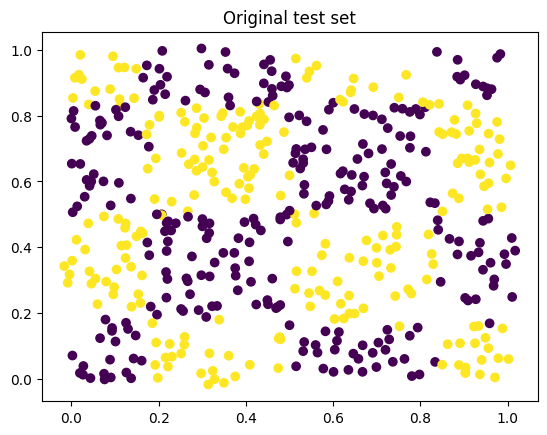

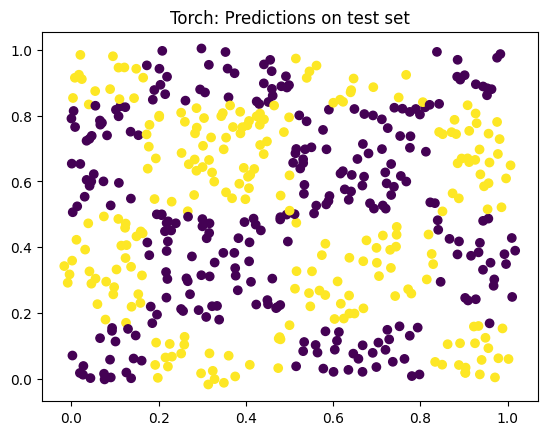

In [9]:
torch_model.eval()
# pylint: disable=not-callable
fp32_pred = (
    torch_model(torch.tensor(X_test).float().to(device)).cpu().argmax(1).float().detach().numpy()
)

# pylint: enable=not-callable

plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test.astype(numpy.float64))
plt.title("Original test set")
plt.show()

plt.scatter(X_test[:, 0], X_test[:, 1], c=fp32_pred)
plt.title("Torch: Predictions on test set")
plt.show()

### Import and test the quantization aware trained model in Concrete ML

Note that the model will have float inputs and outputs in torch, but the inputs and outputs will
need additional quantization in Concrete ML. This may lower the accuracy depending on the input and output quantizers.

In [10]:
# We need to unprune the model before compiling
torch_model.unprune()

In [11]:
# Move torch_model to CPU
torch_model = torch_model.cpu()

In [12]:
# Compile the model using a representative input-set
quantized_numpy_module = compile_brevitas_qat_model(torch_model, X_train)

Compilation device override, was 'cpu' -> change to 'cuda'


In [13]:
prediction_simulated = test_in_fhe(quantized_numpy_module, X_test, y_test, simulate=True)

FHE (simulation) accuracy: 96.00% on 500 examples.


In [14]:
# Reduce the test set for faster running time
FHE_SAMPLE = 10

prediction_fhe = test_in_fhe(
    quantized_numpy_module, X_test[:FHE_SAMPLE], y_test[:FHE_SAMPLE], simulate=False
)

Generating key
Key generation finished in 9.62 seconds


Inferences finished in 35.76 seconds (3.58 seconds/sample)
FHE accuracy: 100.00% on 10 examples.


In [15]:
class TorchSKLearnWrapper:
    def __init__(self, torch_model):
        self.torch_model = torch_model
        self.fitted = True

    def fit(self):
        return self

    @staticmethod
    def __sklearn_is_fitted__():
        return True

    def predict(self, X):
        self.torch_model.eval()
        y_pred = self.torch_model(torch.tensor(X).float()).argmax(1).float().detach().numpy()
        return y_pred

    def predict_proba(self, X):
        self.torch_model.eval()
        y_pred = self.torch_model(torch.tensor(X).float())[:, 1].float().detach().numpy()
        return y_pred

In [16]:
class ConcreteSKLearnWrapper:
    def __init__(self, quantized_module: QuantizedModule):
        self.quantized_module = quantized_module
        self.fitted = True

    def fit(self):
        return self

    @staticmethod
    def __sklearn_is_fitted__():
        return True

    def predict(self, X, progress_bar=False):
        predictions = numpy.zeros((X.shape[0],))
        for idx, x in enumerate(tqdm(X, disable=not progress_bar)):
            predictions[idx] = self.quantized_module.forward(
                numpy.expand_dims(x, 0), fhe="simulate"
            ).argmax(axis=1)
        return predictions

    def predict_proba(self, X, progress_bar=False):
        predictions = numpy.zeros(shape=(X.shape[0], 2))
        for idx, x in enumerate(tqdm(X, disable=not progress_bar)):
            predictions[idx] = self.quantized_module.forward(
                numpy.expand_dims(x, 0), fhe="simulate"
            )[0]
        return predictions

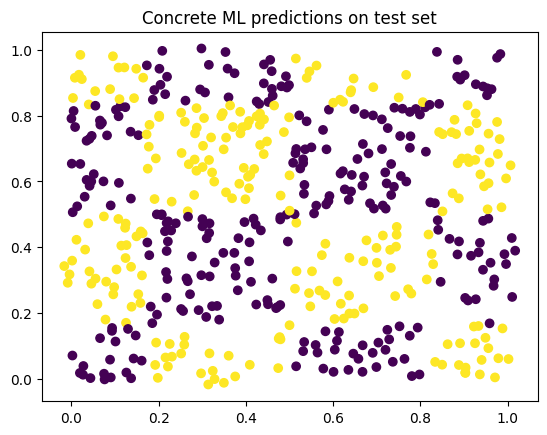

In [17]:
plt.scatter(X_test[:, 0], X_test[:, 1], c=prediction_simulated)
plt.title("Concrete ML predictions on test set")
plt.show()

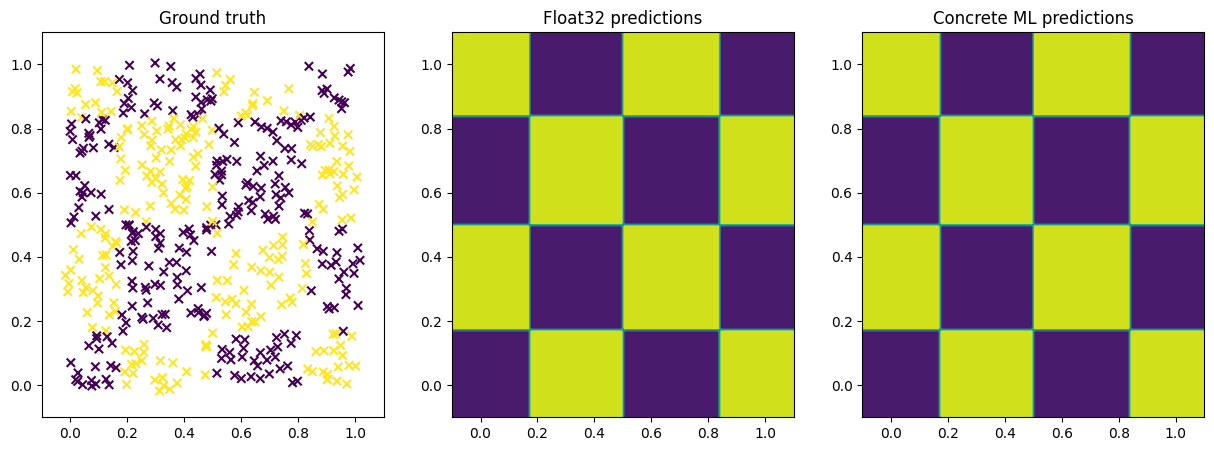

In [18]:
epsilon = 0.1
base = 5
max_value = 1 + epsilon
min_value = 0 - epsilon
grid_resolution = 100
fig, axs = plt.subplots(figsize=(base * 3, base), ncols=3)
for ax in axs:
    ax.set_xlim([min_value, max_value])
    ax.set_ylim([min_value, max_value])

xx0, xx1 = numpy.meshgrid(
    numpy.linspace(min_value, max_value, grid_resolution),
    numpy.linspace(min_value, max_value, grid_resolution),
)

X_grid = numpy.c_[xx0.ravel(), xx1.ravel()]
y_pred_torch = TorchSKLearnWrapper(torch_model).predict(X_grid)
y_pred_concrete = ConcreteSKLearnWrapper(quantized_numpy_module).predict(X_grid)

axs[1].contourf(xx0, xx1, y_pred_torch.reshape(xx0.shape))
axs[2].contourf(xx0, xx1, y_pred_concrete.reshape(xx0.shape))

axs[0].scatter(X_test[:, 0], X_test[:, 1], c=prediction_simulated, marker="x")
axs[0].set_title("Ground truth")
axs[1].set_title("Float32 predictions")
axs[2].set_title("Concrete ML predictions")
plt.show()

### Conclusion

In this notebook we showed how to implement a quantization aware training neural network with brevitas.
We showed that using QAT and pruning we can obtain good accuracy while training is robust, i.e., the network trains
well with different random initializations, optimizer and hyper-parameter settings. 

The accuracy of the QAT network in FHE is ~92.40%. QAT networks have the same accuracy between their
float torch versions and their integer **Concrete ML** FHE versions. Note that a network with similar 
topology to the one implemented here, trained in floating point with no QAT, 
and quantized post-training, obtains only 58% accuracy (not showed in this notebook).